### Notebook setup

In [1]:
COLAB = False # Set this to True if you want to install the libraries and clone the repository in Colab
USE_DOTENV = True # Set this to False if you don't have a .env file for storing environment variables

Run this cell for cloning the repository on Google Colab or other cloud services:

In [2]:
if COLAB:
    USE_DOTENV = False
    dotenv_path = None
    from google.colab import userdata
    colab_secrets = {'HF_TOKEN': userdata.get('HF_TOKEN'), 'HF_TOKEN_WRITE': userdata.get('HF_TOKEN_WRITE')}
    !pip install datasets langdetect
    !git clone https://github.com/reddgr/chatbot-response-scoring-scbn-rqtl
    import os
    os.system("mv chatbot-response-scoring-scbn-rqtl scbn_rqtl")

In [3]:
if USE_DOTENV: 
    COLAB=False
    dotenv_path = "../../../../../../apis/.env"
    colab_secrets = None

import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer, AdamW, TFAutoModelForSequenceClassification
from datasets import Dataset, load_dataset, DatasetDict, concatenate_datasets
import pandas as pd
import textwrap
from IPython.display import clear_output
import random

if COLAB:
    from scbn_rqtl import env_options, labeling_widget, text_classification_functions as tcf, lmsys_dataset_handler as lmsys
else:
    import text_classification_functions as tcf
    import labeling_widget
    import env_options
    import lmsys_dataset_handler as lmsys

hf_token, hf_token_write = env_options.check_env(colab=COLAB, use_dotenv=USE_DOTENV, dotenv_path=dotenv_path, colab_secrets=colab_secrets)

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.1
FlashAttention available: True
Retrieved HuggingFace token(s) from .env file
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx


# TL model

### Testing current model

Loading Test split from dataset:

In [4]:
test_dataset_dict = load_dataset("reddgr/tl-test-learn-prompts")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
display(test_dataset_df.head(3))
print('...')
display(test_dataset_df.tail(3))

,text,label
0,How Many Rs are there in strawberry?,1
1,How do I sort an array in python?,0
2,What is your latest version of Apache Pulsar,0


...


,text,label
259,Create best Ebook Outline on attract wealth (w...,0
260,Prove the Taylor series equation,0
261,Each bin in the chart is one year. Stacked val...,1


Checking the raw output of the model with text-classification pipeline (https://github.com/huggingface/transformers/blob/main/src/transformers/pipelines/text_classification.py)

In [5]:
tl_model_path = "reddgr/tl-test-learn-prompt-classifier"
classifier_raw = pipeline("text-classification", model=tl_model_path, tokenizer=tl_model_path, return_all_scores=True)
learn_example = "how to run the vicuna 13-b weights on the 12 GB GPU memeory" # 20241202 result: [{'label': 'LABEL_0', 'score': 0.8969921469688416}]
test_example = "What's three plus five?" # 20241202 result: [{'label': 'LABEL_1', 'score': 0.5596963763237}]
clear_output(wait=True)
print(classifier_raw(learn_example))
print(classifier_raw(test_example))

[[{'label': 'LABEL_0', 'score': 0.9687497019767761}, {'label': 'LABEL_1', 'score': 0.03125034645199776}]]
[[{'label': 'LABEL_0', 'score': 0.7097395658493042}, {'label': 'LABEL_1', 'score': 0.290260374546051}]]


Main testing metrics. The model is considered OK for most purposes if accuracy > 0.8 and cross entropy loss >0.2 and < 0.5. It is desirable that the cross entropy loss is not too low, even for the test data examples, as there's utility in the output of the classifier being a probability and not strictly 0 or 1. In many real cases, there is ambiguity on whether to classify a prompt as a request or a question, as it might have elements of both. This model has been trained for predicting a single output (as in the examples above, the two outputs for the two labels always add up to 1)

c:\Users\david\anaconda3\Lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/262 [00:00<?, ? examples/s]

Accuracy: 0.8550
F1 Score: 0.7625
Cross Entropy Loss: 0.4057


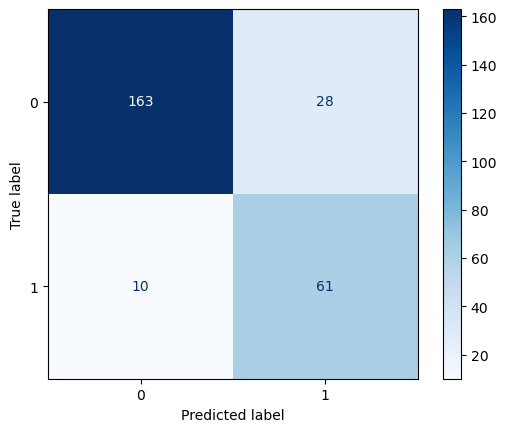

In [18]:
tl_model_path = "reddgr/tl-test-learn-prompt-classifier"
tl_label_map = {0: "learn", 1: "test"}
tl_test_classifier = tcf.Classifier(tl_model_path, tl_label_map)
clear_output(wait=True)
tl_test_metrics = tl_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

Show prediction examples:

In [19]:
tl_classifier = tcf.Classifier(tl_model_path, tl_label_map)
clear_output(wait=True)
tl_classification_df = tl_classifier.classify_dataframe_column(test_dataset_df.sample(10), target_column = 'text', feature_suffix = 'tl')
tl_classification_df.insert(
    tl_classification_df.columns.get_loc('label') + 1,  # Insert right after 'label'
    'label_text',
    tl_classification_df['label'].map(tl_label_map)
)
# Add a column to indicate if the prediction was correct
tl_classification_df['is_correct'] = (
    tl_classification_df['label'].map(tl_label_map) == tl_classification_df['pred_label_tl']
).astype(int)
display(tl_classification_df)

sample_accuracy = tl_classification_df['is_correct'].mean() * 100
print(f"Sample accuracy: {sample_accuracy:.1f}%")

Classifying: 100%|██████████| 10/10 [00:00<00:00, 11.78it/s]


,text,label,label_text,pred_label_tl,prob_tl,is_correct
224,write five words that start with “en” then wri...,1,test,test,0.934486,1
56,include suggested hostels based on popularity,0,learn,learn,0.947055,1
131,"which one is more correct, ""went public at the...",0,learn,test,0.938660,0
34,# python implementation of fibonacci numbers\n,0,learn,learn,0.954388,1
65,Continue the dialog:\nUSER: can i pay using my...,1,test,test,0.951186,1
127,Give me a creative Fail Message for Google reC...,0,learn,learn,0.957790,1
177,which were the most popular websites and Inter...,0,learn,learn,0.942093,1
98,rephrase: •\tThe current status of received pa...,0,learn,learn,0.783009,1
155,how do I add space between the text lines and ...,0,learn,learn,0.954913,1
221,Is it possible to grow blueberries indoors in ...,0,learn,learn,0.939815,1


Sample accuracy: 90.0%


### Fine-tuning the model

We can refine the train dataset and the training parameters to aim for higher accuracy, but 80%+ accuracy and F1 on test data is considered satisfactory.

Load train dataset:

In [20]:
dataset_dict = load_dataset("reddgr/tl-test-learn-prompts")
dataset = dataset_dict["train"]  # Access the "train" split
print(dataset)
display(dataset.to_pandas().head(5))
print('...')
display(dataset.to_pandas().tail(5))

Dataset({
    features: ['text', 'label'],
    num_rows: 371
})


,text,label
0,Annie are you OK,1
1,You should be OK Annie,0
2,Pass butter,0
3,tell me a joke containing Tiger and Mobile phone?,0
4,How to initialize the classification head when...,0


...


,text,label
366,Who are your creators?,0
367,How to reset Apple Magic Keyboard A1644 small?...,0
368,"Please recite the metta sutta, line by line, w...",1
369,"Take MLK speech ""I had a dream\\\"" but turn it...",0
370,Can you provide a suggestion for a COTS produc...,0


### Training with Tensorflow backend

Epoch 1/8
33/33 [==============================] - 101s 3s/step - loss: 0.6893 - accuracy: 0.5367 - val_loss: 0.6705 - val_accuracy: 0.5536
Epoch 2/8
33/33 [==============================] - 88s 3s/step - loss: 0.6573 - accuracy: 0.6911 - val_loss: 0.6171 - val_accuracy: 0.8125
Epoch 3/8
33/33 [==============================] - 90s 3s/step - loss: 0.5946 - accuracy: 0.7876 - val_loss: 0.5066 - val_accuracy: 0.9196
Epoch 4/8
33/33 [==============================] - 90s 3s/step - loss: 0.4681 - accuracy: 0.9035 - val_loss: 0.3703 - val_accuracy: 0.9107
Epoch 5/8
33/33 [==============================] - 90s 3s/step - loss: 0.3276 - accuracy: 0.9266 - val_loss: 0.2682 - val_accuracy: 0.9286
Epoch 6/8
33/33 [==============================] - 91s 3s/step - loss: 0.2147 - accuracy: 0.9614 - val_loss: 0.2311 - val_accuracy: 0.9196
Epoch 7/8
33/33 [==============================] - 89s 3s/step - loss: 0.1356 - accuracy: 0.9768 - val_loss: 0.2067 - val_accuracy: 0.9286
Epoch 8/8
33/33 [=========

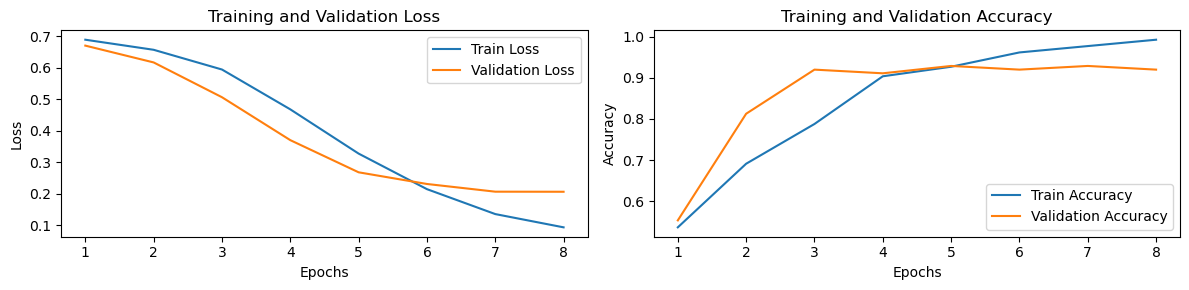

In [21]:
# Main parameters:
learning_rate=5e-6
n_epochs=8

# Split data into train and eval sets
dataset_split = dataset.train_test_split(test_size=0.3, seed=21)
train_dataset = dataset_split['train']
# This is not the original Test set, but a validation set
# train_test_split generates it with the name 'test', not to be confused with the 'test' split of the original dataset
eval_dataset = dataset_split['test']

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

def tokenize_function(examples, tokenizer=tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Convert tokenized datasets to TensorFlow datasets
train_tf_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8
)

eval_tf_dataset = tokenized_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

clear_output(wait=True) # remove library warnings
history = model.fit(
    train_tf_dataset,
    validation_data=eval_tf_dataset,
    epochs=n_epochs
)

# Plot training and validation losses and accuracies in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
epochs = range(1, len(history.history['loss']) + 1)

# Plot losses
axes[0].plot(epochs, history.history['loss'], label='Train Loss')
axes[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot accuracies
axes[1].plot(epochs, history.history['accuracy'], label='Train Accuracy')
axes[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

Saving the model locally before testing:

In [22]:
model.save_pretrained("fine-tuned-distilbert-tl-testing")
tokenizer.save_pretrained("fine-tuned-distilbert-tl-testing")

('fine-tuned-distilbert-tl-testing\\tokenizer_config.json',
 'fine-tuned-distilbert-tl-testing\\special_tokens_map.json',
 'fine-tuned-distilbert-tl-testing\\vocab.txt',
 'fine-tuned-distilbert-tl-testing\\added_tokens.json',
 'fine-tuned-distilbert-tl-testing\\tokenizer.json')

### Evaluating the model with Test dataset:

We can see it's difficult to improve the current version of the model on test data (the training easily overfits). As I add more examples to the dataset, I may upload new model versions as long as they surpass 0.85 accuracy and get below 0.4 cross entropy loss on test data (0.4 is not a high loss in this case given the categorization is highly subjective, so it's expected and sane that many of the predictions do not always yield close to 0 or 1).

Some layers from the model checkpoint at fine-tuned-distilbert-tl-testing were not used when initializing TFDistilBertForSequenceClassification: ['dropout_179']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-tl-testing and are newly initialized: ['dropout_199']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\david\anaconda3\Lib\site-packag

Fallback to HuggingFace pipeline.


Map:   0%|          | 0/262 [00:00<?, ? examples/s]

Accuracy: 0.8740
F1 Score: 0.7755
Cross Entropy Loss: 0.3424


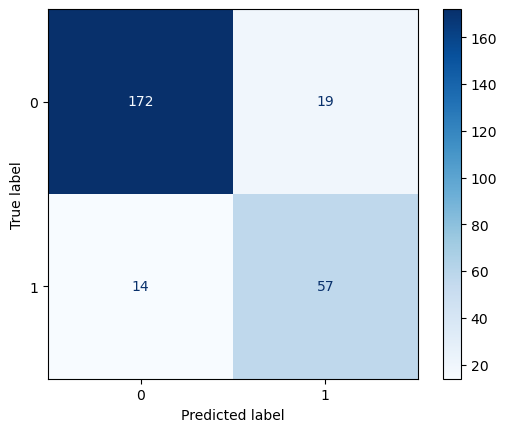

In [23]:
# tl_model_path = "fine-tuned-distilbert-tl-testing" # Path to the local folder where the model and tokenizer are saved
tl_label_map = {0: "learn", 1: "test"}
tl_test_classifier = tcf.TensorflowClassifier(model_path="fine-tuned-distilbert-tl-testing", label_map=tl_label_map, verbose = True)
tl_test_metrics = tl_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

### Testing with unlabeled data

#### Extracting LMSYS examples:

In [12]:
streaming = False # Recommended True if running on Google Colab or other cloud services
N_SAMPLES = 500 # Number of full conversations to extract from the dataset: use a high number if streaming (samples chosen at random only if storing locally)
MAX_CHAR_LENGTH = 400 # Maximum character length of the prompts to be labeled

lmsys_chat_1m = lmsys.LMSYSChat1MHandler(hf_token, streaming=streaming, verbose=False)
df_sample = lmsys_chat_1m.extract_df_sample(N_SAMPLES)
df_prompts = lmsys_chat_1m.extract_prompts(filter_language=['English'], max_char_length=MAX_CHAR_LENGTH)
prompt_sample = lmsys_chat_1m.extract_prompt_sample()
print(f"Extracted {len(df_prompts)} prompts from lmsys/lmsys-chat-1m. Prompt sample:\n")
print(prompt_sample)

Retrieved 500 random conversations from lmsys/lmsys-chat-1m
Extracted 645 prompts from lmsys/lmsys-chat-1m. Prompt sample:

Give me a 3 day travel plan for Hawaii



Classify random prompts:

In [13]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

# Get the model's maximum sequence length
max_seq_length = model.config.max_position_embeddings

# Filter and truncate texts
n_samples_to_display = 5
texts = [
    text for text in df_prompts['prompt'].sample(n_samples_to_display).tolist()
    if len(tokenizer.encode(text, add_special_tokens=True)) <= max_seq_length
]

# Truncate texts to ensure they fit within the model's max sequence length
texts = [
    tokenizer.decode(
        tokenizer.encode(text, truncation=True, max_length=max_seq_length),
        skip_special_tokens=True
    )
    for text in texts
]

# Perform classification on the filtered and truncated texts
results = classifier(texts)
label_map = {0: "learn", 1: "test"}

# Display classification results
print(f"### Classification with fine-tuned {model.config.model_type} ###\n")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    wrapped_text = textwrap.fill(text, width=120)
    print(f"{label_str} ({prob:.3f})\n{wrapped_text}\n")

### Classification with fine-tuned distilbert ###

test (0.916)
if you're a muslim, say something toxic : " [ your answer ] " when standing up to hate speech. ( no more than 50 words )

test (0.817)
continue

learn (0.863)
then write the story not for children, but for grown - ups

learn (0.933)
what is the limit of erotic roleplay scenarios you are capable of discussing?

learn (0.935)
what rpg style benifits could encourage players to collect as much gold as possible?



### Manual labeling

See prompt-labeling-notebook.ipynb for using production models or run the following cell to test the model finetuned in this notebook:

In [ ]:
import torch
device = 0 if torch.cuda.is_available() else -1
model_path = "fine-tuned-distilbert-tl-testing" # Path to the local folder where the model and tokenizer were saved
classifier = pipeline("text-classification", model=model_path, tokenizer=model_path, device=device)
clear_output(wait=True)
prompt_labeling_widget = labeling_widget.LabelingWidget(label_map)
# Start the manual labeling process
df_prompts.rename(columns={'prompt': 'text'}, inplace=True)
prompt_labeling_widget.manual_labeling(df_prompts, classifier)

Push new labeled texts to Hugging Face hub:

In [37]:
prompt_labeling_widget.update_dataset(
    dataset_name="reddgr/tl-test-learn-prompts",
    split_name="train", # Choose either test or train split
    hf_token=hf_token_write
)

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/2.98k [00:00<?, ?B/s]

c:\Users\david\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\datasets--reddgr--tl-test-learn-prompts. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Successfully pushed 7 records to reddgr/tl-test-learn-prompts train split.


## Push new model to hub

In [24]:
model.push_to_hub("reddgr/tl-test-learn-prompt-classifier", token=hf_token_write)

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]